In [112]:
import os 
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import pandas as pd
import random

import tensorflow as tf
import keras
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, Rescaling, RandomRotation, Resizing, RandomFlip, RandomZoom, RandomContrast, RandomBrightness
from keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
ROOT_DATASET = ("../traffic-sign-classification/Dataset")

TRAINING_DATA_DIR = os.path.join(ROOT_DATASET, 'train')
TEST_JPG_DATA_DIR= os.path.join(ROOT_DATASET, 'test')
CSV_TEST_DATA_PATH = os.path.join(ROOT_DATASET, 'GT-final_test.csv')

In [3]:
categories ={
            0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' 
}

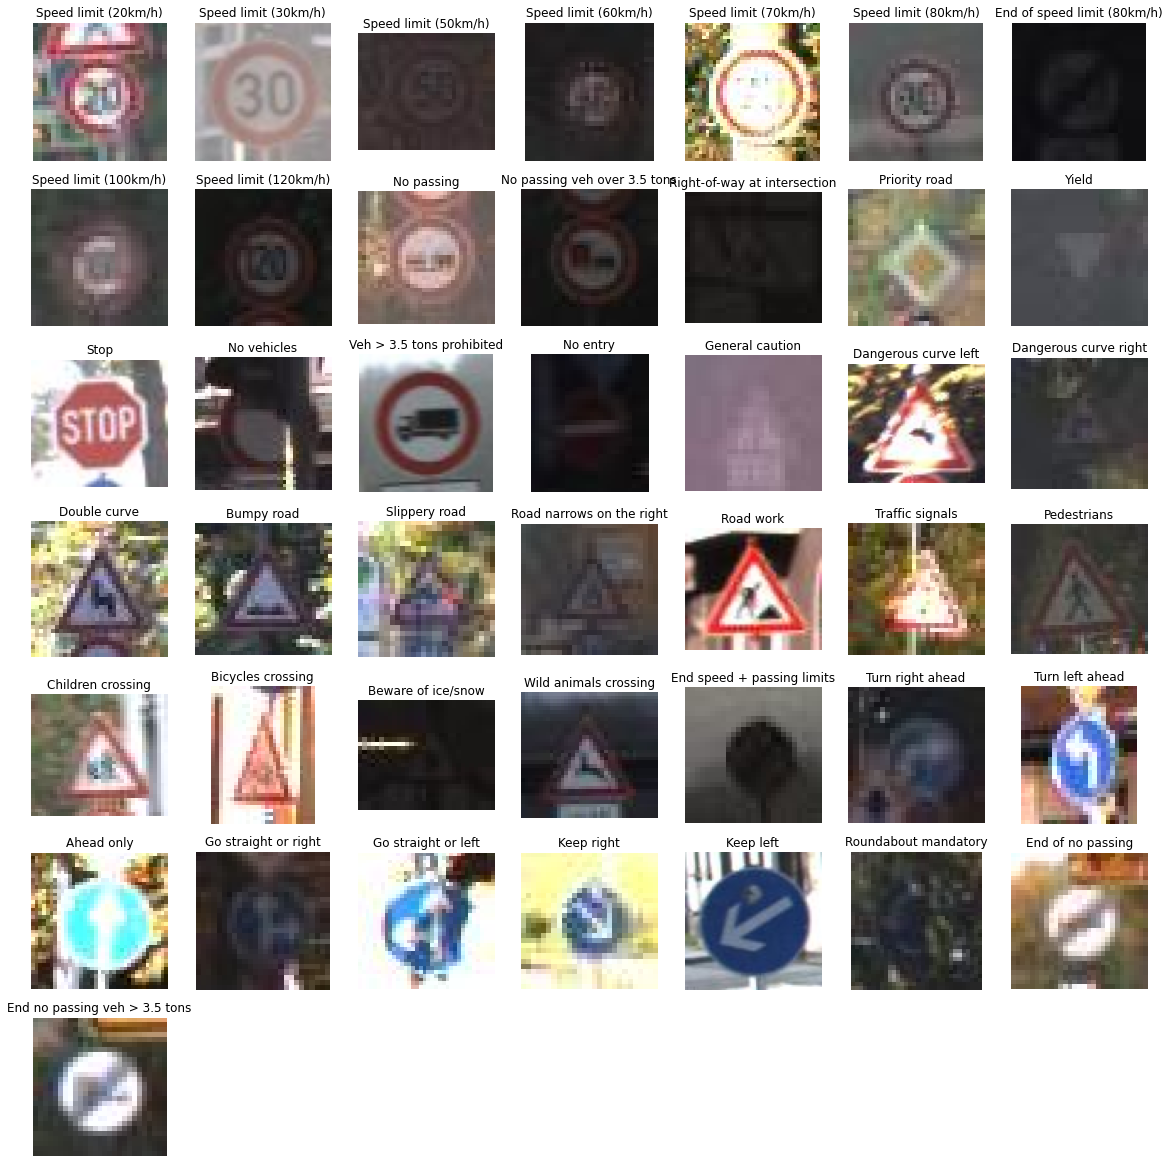

In [4]:
preprocessed_training_dirs = [d for d in os.listdir(TRAINING_DATA_DIR) 
               if os.path.isdir(os.path.join(TRAINING_DATA_DIR, d))]
preprocessed_training_dirs.sort()

training_images = []
for training_dir in preprocessed_training_dirs:
    training_images.append(os.path.join(TRAINING_DATA_DIR, training_dir, "00000_00000.jpg"))

i = 0
plt.figure(figsize=(20, 30))
for image in training_images:
    plt.subplot(10,7, i + 1)
    plt.axis('off')
    plt.title("{}".format(categories[i]))
    i += 1
    plt.imshow(Image.open(image))
plt.show()

In [2]:
IMAGE_SHAPE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 100
VERBOSE = 2

In [6]:
df = pd.read_csv(CSV_TEST_DATA_PATH, delimiter=',', nrows = None)

nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 12630 rows and 8 columns


In [7]:
df.head(5)

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000.jpg,53,54,6,5,48,49,16
1,00001.jpg,42,45,5,5,36,40,1
2,00002.jpg,48,52,6,6,43,47,38
3,00003.jpg,27,29,5,5,22,24,33
4,00004.jpg,60,57,5,5,55,52,11


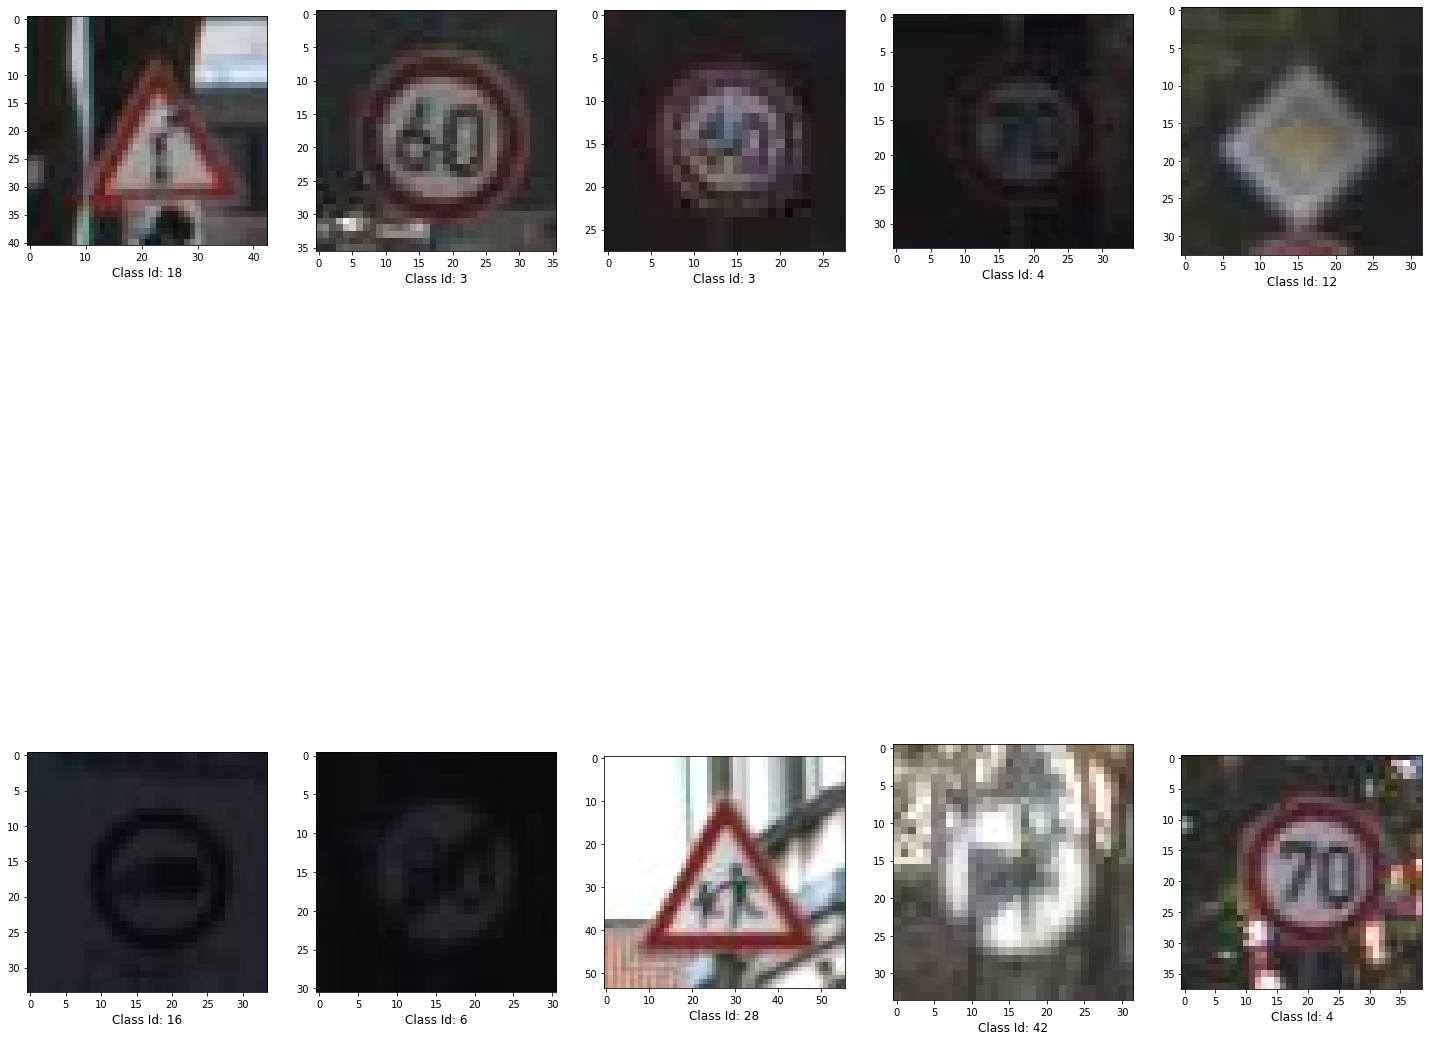

In [8]:
img_test = df["Filename"].values

plt.figure(figsize=(25,25))

for i in range(1,11):
    plt.subplot(2,5,i)
    random_img_path = TEST_JPG_DATA_DIR + '/' + random.choice(img_test)
    rand_img = imread(random_img_path)
    img_filename = os.path.basename(random_img_path)
    
    class_id = df[df["Filename"] == img_filename]["ClassId"].values[0]
    plt.imshow(rand_img)
    plt.grid(visible=0)
    plt.xlabel(f"Class Id: {class_id}", fontsize=12)

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  TRAINING_DATA_DIR,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SHAPE),
  batch_size=BATCH_SIZE
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
  TRAINING_DATA_DIR,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SHAPE),
  batch_size=BATCH_SIZE
)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


In [10]:
class_names = train_dataset.class_names
NUM_CLASSES = len(class_names)

In [123]:
for images, labels in train_dataset:
    print(images.shape)    
    print(labels.shape)

In [14]:
resize_and_rescale = Sequential([
    Rescaling(1./255)
])

In [15]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical", input_shape = (128, 128, 3)),
    RandomRotation(0.2),
    RandomZoom(height_factor=0.2, width_factor=0.2),
    RandomContrast(0.1),
    RandomBrightness(0.1)
])

In [84]:
# MODEL 
model = Sequential ([
    data_augmentation,
    resize_and_rescale,
    
    Conv2D(filters = 8, kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    
    DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'),
    
    Conv2D(filters = 16, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    
    DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'),
        
    Conv2D(filters = 32, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
            
    Conv2D(filters = 32, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    
    DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'),
                
    Conv2D(filters = 64, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
                
    Conv2D(filters = 64, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    
    DepthwiseConv2D(kernel_size = 3, strides = 2, padding = 'same', activation = 'relu'),
                
    Conv2D(filters = 128, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
                
    Conv2D(filters = 128, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu'),
    BatchNormalization(),  
    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
                
    Conv2D(filters = 128, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu'),
    BatchNormalization(),  
    
    DepthwiseConv2D(kernel_size = 3, strides = 1, padding = 'same', activation = 'relu'),
    
    Conv2D(filters = 256, kernel_size = 1, strides = 1, padding = 'same', activation = 'relu'),
    BatchNormalization(),
    
    GlobalAveragePooling2D(),
    
    Dropout(0.5),
    
    Flatten(),
    
    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(64, activation = 'relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation = 'softmax')
])

In [85]:
model.compile(optimizer='adam',
              loss = SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [86]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_130 (Conv2D)         (None, 64, 64, 8)         224       
                                                                 
 batch_normalization_128 (B  (None, 64, 64, 8)         32        
 atchNormalization)                                              
                                                                 
 depthwise_conv2d_111 (Dept  (None, 32, 32, 8)         80        
 hwiseConv2D)                                                    
                                                                 
 conv2d_131 (Conv2D)         (None, 32, 32, 16)      

In [96]:
tf.keras.utils.plot_model(
    model, to_file='../traffic-sign-classification/Output/model_architecture.png', show_shapes=True, show_layer_names=True,
    rankdir='TB'
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [97]:
checkpoint_path = '../traffic-sign-classification/Output/fdmobilenet_gtsrb.h5'

In [ ]:
checkpointer = ModelCheckpoint(filepath=checkpoint_path,
                               verbose=1,
                               save_best_only=True)

In [ ]:
history = model.fit(X_train,
                    y_train_encoded, 
                    validation_data=(X_val, y_val_encoded), 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=[checkpointer],
                    verbose=VERBOSE)

In [ ]:
print(history.history.keys())

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()